In [11]:
from river import stream, tree, metrics
from river.datasets import synth
import random
from river import drift
import river
import matplotlib.pyplot as plt
import river.metrics as metrics
import river.naive_bayes as naive_bayes
import river.drift
from stream_generator import FeatureImportanceChangeGenerator
from feature_selection import run_Boruta, plot_imp_history
import numpy as np
import pandas as pd
from collections import deque

In [12]:
generator = FeatureImportanceChangeGenerator(n_features=20, n_important_features=5, random_seed=43, importance_change_interval=1)
rng = random.Random(12345)
adwin = drift.ADWIN()
hddm_a = drift.binary.HDDM_A() # average
hddm_w = drift.binary.HDDM_W() # weighted
kswin = drift.KSWIN()

In [13]:
def plot_accuracy_with_drift(epochs, accuracies, real_drift_points, detected_drift_points, regular_change_points):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, accuracies, label='Accuracy', color='blue')
    for i, drift in enumerate(real_drift_points):
        plt.axvline(x=drift, color='violet', linestyle='solid',
                    label='Real Drift Occured' if i == 0 else "")
    for i, drift in enumerate(detected_drift_points):
        plt.axvline(x=drift, color='indigo', linestyle='dashed',
                    label='Drift Detected' if i == 0 else "")
    for i, drift in enumerate(regular_change_points):
        plt.axvline(x=drift, color='lightgreen', linestyle='dashed',
                    label='Drift Detected' if i == 0 else "")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Time with Drift Detection")
    plt.legend()
    plt.show()

def update_metrics(model, x, y, acc, classification_report, epoch, accuracies, epochs):
    y_pred = model.predict_one(x)
    model.learn_one(x, y)
    if y_pred is not None:
        classification_report.update(y, y_pred)
        acc.update(y, y_pred)
        accuracies.append(acc.get())
        epochs.append(epoch)
    return model, y_pred

def check_drift(drift_detector, y, y_pred, epoch, print_warning):
    drift_detector.update(y == y_pred)
    drift_detected = drift_detector.drift_detected
    warning_detected = getattr(drift_detector, "warning_detected", False)

    if print_warning and warning_detected:
        print(f"Warning detected at index {epoch}, input value: {y}")

    if drift_detected:
        print(f"Drift detected at index {epoch}, input value: {y}")
    return drift_detected


In [14]:
def run_drift_detection(generator, drift_detector, boruta_samples=100, n_samples=10_000, n_history=1000, print_warning=False):
    classification_report = metrics.ClassificationReport()
    acc = metrics.Accuracy()
    model = tree.HoeffdingTreeClassifier()

    accuracies = []
    detected_drift_points = []
    regular_model_changes = []
    epochs = []
    
    
    previous_xs, previous_ys = deque(maxlen=n_history), deque(maxlen=n_history)
    for x, y in generator.take(boruta_samples):
        previous_xs.append(x)
        previous_ys.append(y)
    
    
    boruta_result = run_Boruta(pd.DataFrame(previous_xs), np.array(previous_ys))
    accepted_features = list(boruta_result.accepted)
    accepted_features.extend(list(boruta_result.tentative))
    

    for epoch, (x, y) in enumerate(generator.take(n_samples-boruta_samples)):
        # update history
        previous_xs.append(x)
        previous_ys.append(y)

        # single element prediction
        important_xs = {key: value for key, value in x.items() if key in accepted_features}
        model, y_pred = update_metrics(model, important_xs, y, acc, classification_report, epoch, accuracies, epochs)

        # check drift on y
        if y_pred is not None and check_drift(drift_detector, y, y_pred, epoch, print_warning):
            boruta_result = run_Boruta(pd.DataFrame(previous_xs), np.array(previous_ys))
            accepted_features = list(boruta_result.accepted)
            accepted_features.extend(list(boruta_result.tentative))
            
            model = tree.HoeffdingTreeClassifier()
            detected_drift_points.append(epoch)
        
        # check feature importance every x epochs:
        elif epoch % n_history == 0:
            boruta_result = run_Boruta(pd.DataFrame(previous_xs), np.array(previous_ys))
            new_accepted_features = list(boruta_result.accepted)
            new_accepted_features.extend(list(boruta_result.tentative))
            if len(set(accepted_features).difference(new_accepted_features)) > len(accepted_features) / 2:
                print(f"Feature importance changed at epoch {epoch}.")
                accepted_features = new_accepted_features
                model = tree.HoeffdingTreeClassifier()
                regular_model_changes.append(epoch)
        
        if epoch % 1_000 == 0:
            print(f'Epoch {epoch}, {acc}')

    print('\n')
    print(classification_report)
    
    real_drfit_points = list(generator.importance_history.keys())
    
    plot_accuracy_with_drift(epochs, accuracies, real_drfit_points, detected_drift_points, regular_model_changes)

c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\eBoruta\algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.c

Epoch 0, Accuracy: 0.00%
Drift detected at index 608, input value: 1


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\eBoruta\algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(
Boruta trials: 100%|██████████| 30/30 [00:01<00:00, 15.05it/s, accepted=3, rejected=16, tentative=1]
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning

Epoch 1000, Accuracy: 82.88%
Drift detected at index 1601, input value: 0


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\eBoruta\algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(
Boruta trials: 100%|██████████| 30/30 [00:02<00:00, 14.35it/s, accepted=3, rejected=15, tentative=2]
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning

Epoch 2000, Accuracy: 81.13%
Drift detected at index 2658, input value: 0


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\eBoruta\algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(
Boruta trials: 100%|██████████| 30/30 [00:02<00:00, 14.94it/s, accepted=5, rejected=14, tentative=1]
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning

Epoch 3000, Accuracy: 81.98%
Drift detected at index 3139, input value: 0


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\eBoruta\algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(
Boruta trials: 100%|██████████| 30/30 [00:02<00:00, 14.81it/s, accepted=4, rejected=15, tentative=1]
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning

Drift detected at index 3908, input value: 0


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\eBoruta\algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(
Boruta trials: 100%|██████████| 30/30 [00:02<00:00, 14.13it/s, accepted=4, rejected=15, tentative=1]
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning

Epoch 4000, Accuracy: 80.95%
Drift detected at index 4773, input value: 1


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\eBoruta\algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(
Boruta trials: 100%|██████████| 30/30 [00:02<00:00, 14.47it/s, accepted=5, rejected=12, tentative=3]
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning

Epoch 5000, Accuracy: 80.02%
Drift detected at index 5670, input value: 0


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\eBoruta\algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(
Boruta trials: 100%|██████████| 30/30 [00:02<00:00, 14.73it/s, accepted=3, rejected=13, tentative=4]
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning

Epoch 6000, Accuracy: 81.36%
Drift detected at index 6503, input value: 1


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\eBoruta\algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(
Boruta trials: 100%|██████████| 30/30 [00:02<00:00, 14.78it/s, accepted=3, rejected=14, tentative=3]
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning

Feature importance changed at epoch 7000.
Epoch 7000, Accuracy: 79.25%
Drift detected at index 7113, input value: 0


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\eBoruta\algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(
Boruta trials: 100%|██████████| 30/30 [00:02<00:00, 14.71it/s, accepted=5, rejected=13, tentative=2]
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning

Epoch 8000, Accuracy: 79.95%
Drift detected at index 8010, input value: 1


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\eBoruta\algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(
Boruta trials: 100%|██████████| 30/30 [00:02<00:00, 14.87it/s, accepted=3, rejected=16, tentative=1]
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning

Epoch 9000, Accuracy: 78.99%
Drift detected at index 9675, input value: 0


Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]c:\Users\kaspr\Documents\Studia\IAD2\DataStreams\ml-in-data-streams\ds_venv\Lib\site-packages\eBoruta\algorithm.py:431: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.features_.imp_history = pd.concat(
Boruta trials: 100%|██████████| 30/30 [00:02<00:00, 13.89it/s, accepted=5, rejected=13, tentative=2]




           Precision   Recall   F1       Support  
                                                  
       0      78.64%   77.60%   78.12%      4915  
       1      78.14%   79.16%   78.65%      4972  
                                                  
   Macro      78.39%   78.38%   78.38%            
   Micro      78.39%   78.39%   78.39%            
Weighted      78.39%   78.39%   78.38%            

                 78.39% accuracy                  


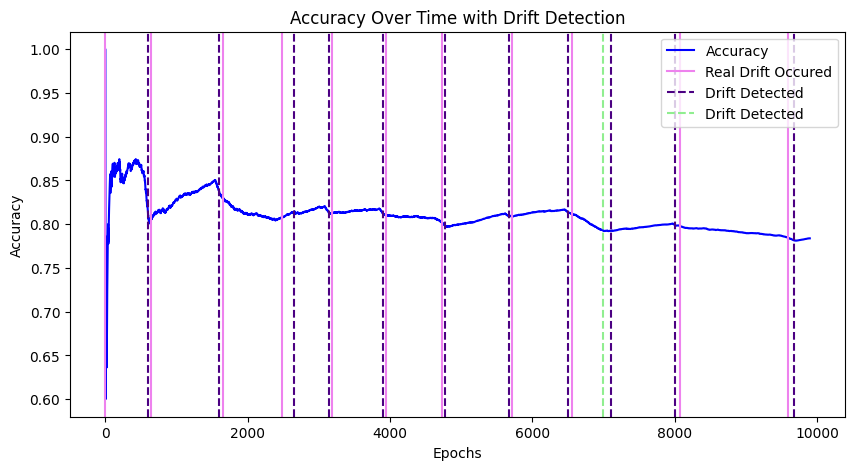

In [15]:
import random

generator = FeatureImportanceChangeGenerator(20, 5, random_seed=random.randint(0, 300), importance_change_interval=10)
run_drift_detection(generator, adwin)

In [16]:
generator.importance_history

{1: (array([14, 15, 17, 18, 19]),
  array([ -0.        ,   0.        ,  -0.        ,   0.        ,
           0.        ,   0.        ,  -0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,  -0.        ,
          -0.        ,  -0.        ,   2.36751627, -15.462526  ,
          -0.        ,  -7.62139738,   3.24314364,   4.00498076])),
 641: (array([ 5, 12, 16, 18, 19]),
  array([ -0.        ,   0.        ,  -0.        ,  -0.        ,
          -0.        ,  -1.25922122,   0.        ,  -0.        ,
           0.        ,  -0.        ,  -0.        ,  -0.        ,
          -3.41658581,  -0.        ,   0.        ,   0.        ,
          -1.00102756,  -0.        ,  -1.65758246, -17.56222107])),
 1652: (array([ 0,  1,  5, 10, 16]),
  array([ -4.63427926, -12.71913784,   0.        ,   0.        ,
           0.        ,   4.61090773,   0.        ,   0.        ,
          -0.        ,  -0.        , -12.61535186,   0.        ,
          -0.        ,   0.        ,   0. 